<a href="https://colab.research.google.com/github/HARINI-RadheyKrishna/Machine_Learning/blob/master/EE599_ML_Systems_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW4 EE599 Systems for Machine Learning, Fall 2023
University of Southern California

Instructors: Arash Saifhashemi, Murali Annavaram

## Prerequisites:

* Set the runtime type to GPU. (Runtime -> Change Runtime Type)

# Initial Setup

This section imports all required packages from PyTorch.



In [3]:
#%matplotlib inline
import scipy.ndimage as ndi
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
grays=plt.get_cmap('gray')
np.set_printoptions(precision=2)


import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from copy import deepcopy


import inspect
import re
import pprint

## Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import sys, os
weights_dir = '/content/drive/MyDrive/ML_Systems/HW4/weights'
data_dir = '/content/drive/MyDrive/ML_Systems/HW4/data'

**Reminder:** set the runtime type to "GPU", or your code will run much more slowly on a CPU.

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Section 2: Convolutional Neural Networks

**Note**: This section is similar to HW2.

The construction of neural networks is facilitated through the utilization of the ``torch.nn`` package within the PyTorch framework.

A standard process for training a neural network involves the following steps:

1. **Neural Network Definition:** The first step entails defining the architecture of the neural network, which encompasses the design of its interconnected layers and the inclusion of learnable parameters, often referred to as weights.

2. **Iterative Data Processing:** Next, the training procedure involves iterating through a dataset containing input samples. Each input is fed into the neural network for processing.

3. **Forward Propagation:** During this phase, the input data is passed through the neural network's layers, activating its neurons through weighted connections and producing an output prediction.

4. **Loss Computation:** The output generated by the network is then compared to the actual desired output, leading to the computation of a loss value. This loss signifies the discrepancy between the predicted outcome and the true value.

5. **Backpropagation:** After calculating the loss, the gradients of the loss with respect to the network's parameters are computed through a process called backpropagation. This entails tracing how changes in the parameters affect the loss.

6. **Gradient Update:** The gradients computed during backpropagation are used to adjust the network's weights. A common method involves updating the weights by subtracting a scaled gradient value from the current weights. The scale factor, known as the learning rate, determines the step size of the update. This update rule can be expressed as: ``weight = weight - learning_rate * gradient``.

Throughout this iterative process, the neural network's parameters are fine-tuned to minimize the loss and enhance its predictive accuracy. This sequence of steps forms the backbone of training neural networks, enabling them to learn and improve their performance over time.

In this assignment we will create a simple CNN.


To begin this section, we will load the CIFAR10 dataset and train a simple convolutional neural network (CNN) to classify the images.

The CIFAR10 dataset has the classes:

* `airplane`
* `automobile`
* `bird`
* `cat`
* `deer`
* `dog`
* `frog`
* `horse`
* `ship`
* `truck`

The images in CIFAR-10 are of size:

* `3x32x32`

i.e. 3-channel color images of `32x32` pixels in size.

To load the data, we use a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, namely,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.


In the following code, we perform the following:

* Define a batch size for processing multiple images in each iteration.
* Create a series of transformations to be applied to the images in the dataset: converting images to tensors and normalizing the pixel values.
* Load the CIFAR10 **training** and **test** datasets, specifying the root directory, training mode, and transformations.
* Construct a DataLoader for the **training** and **test** datasets with batch processing, shuffling, and parallel data loading.

In [13]:
# Set the batch size for data processing
batch_size = 4

# Define the mean values and standard deviation values for normalization
mean_values = (0.5, 0.5, 0.5)  # Mean values for red, green, and blue channels
std_values = (0.5, 0.5, 0.5)   # Standard deviation values for red, green, and blue channels

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),                  # Convert images to tensors
    transforms.Normalize(mean_values, std_values)  # Normalize tensor values
])

# Load the CIFAR10 training dataset and apply the defined transformations
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                        download=True, transform=transform)

# Create a DataLoader to efficiently load and process training data in batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Load the CIFAR10 test dataset and apply the same transformations as for training
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                       download=True, transform=transform)

# Create a DataLoader for test data
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let's view some of the images.

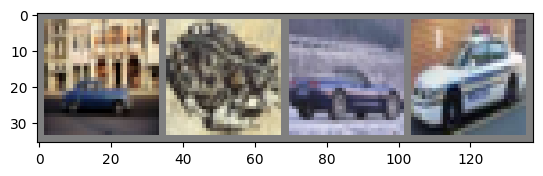

Labels: car   frog  car   car  


In [8]:

# Define a function to display images
def imshow(img):
    # Unnormalize the image
    # The normalization was done using this formula:
    # img_norm = (img - mean) / std
    # So we unnormalize as follows:
    img = img * 0.5 + 0.5

    npimg = img.numpy()


    #The image array is typically stored in the order [height, width, channels],
    #but the plt.imshow function expects the image array to be stored in the
    #order [channels, width, height].
    #The np.transpose function transposes the image array,
    #so that it is stored in the correct order.
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    # Display the image
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show the images using the imshow function
imshow(torchvision.utils.make_grid(images))

# Print labels
print('Labels:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Define a simple CNN that classifies CIFAR images.

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Define the layers of the neural network architecture

        # First convolutional layer: 3 input channels, 6 output channels, kernel size 5x5
        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)

        # Max pooling layer with kernel size 2x2 and stride 2
        self.pool = nn.MaxPool2d(2, 2)

        # Second convolutional layer: 6 input channels, 16 output channels, kernel size 5x5
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)

        # Fully connected (dense) layers

        # First fully connected layer: 16*5*5 input features, 120 output features
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)

        # Second fully connected layer: 120 input features, 84 output features
        self.fc2 = nn.Linear(120, 84, bias=False)

        # Third fully connected layer: 84 input features, 10 output features (for classification)
        self.fc3 = nn.Linear(84, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Forward pass through the neural network

        # Apply first convolutional layer, followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Apply second convolutional layer, followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv2(x)))

        # The output from the convolutional and pooling layers is in the form of a
        # 3D tensor (height, width, depth or channels).
        # To feed this tensor into a fully connected layer,
        # it needs to be flattened into a 1D tensor.
        # Reshape tensor for fully connected layers
        # A2D tensor with a shape of [batch_size, 16 * 5 * 5].
        x = x.view(-1, 16 * 5 * 5)

        # Apply first fully connected layer, followed by ReLU activation
        x = F.relu(self.fc1(x))

        # Apply second fully connected layer, followed by ReLU activation
        x = F.relu(self.fc2(x))

        # Apply third fully connected layer (output layer)
        x = self.fc3(x)

        return x

# Create an instance of the neural network and move it to the specified device (e.g., GPU)
net = Net().to(device)


Train this CNN on the training dataset (this may take a few moments).

In [15]:
def train(model: nn.Module, dataloader: DataLoader):
    # Define the loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD optimizer with momentum

    for epoch in range(2):  # Loop over the dataset for multiple epochs
        running_loss = 0.0

        # Iterate over mini-batches of data
        for i, data in enumerate(dataloader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)  # Move inputs to the specified device
            labels = labels.to(device)  # Move labels to the specified device

            # Zero the gradients in the optimizer
            optimizer.zero_grad()

            # Forward pass + backward pass (backpropagation) + optimization
            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            # Print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # Print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')  # Training loop is complete
    PATH = os.path.join(weights_dir, 'cifar_net.pth')
    torch.save(net.state_dict(), PATH)



In [21]:
train(net, trainloader)

[1,  2000] loss: 2.223
[1,  4000] loss: 1.947
[1,  6000] loss: 1.769
[1,  8000] loss: 1.634
[1, 10000] loss: 1.580
[1, 12000] loss: 1.527
[2,  2000] loss: 1.453
[2,  4000] loss: 1.412
[2,  6000] loss: 1.373
[2,  8000] loss: 1.363
[2, 10000] loss: 1.328
[2, 12000] loss: 1.318
Finished Training


RuntimeError: ignored

Now that the CNN has been trained, let's test it on our test dataset.

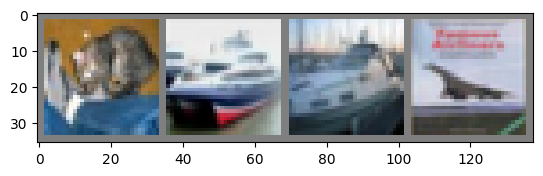

GroundTruth:  cat   ship  ship  plane
Predicted:  dog   ship  car   ship 


In [22]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


# net = Net()
# net.load_state_dict(torch.load(PATH))
net.cuda()
images = images.cuda()
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Let us look at how the network performs on the whole dataset.


In [23]:

# A function to evaluate the performance of a given neural network model
# using a test dataset.
# It calculates the accuracy of the model's predictions on the test data.
def calculate_accuracy(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct_predictions = 0  # Initialize the count of correctly predicted samples
    total_samples = 0    # Initialize the count of total samples
    inference_count = 0  # Initialize the count of inferences made

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_data in dataloader:
            images, labels = batch_data  # Separate images and labels from the batch

            images = images.to(device)  # Move images to the specified device
            labels = labels.to(device)  # Move labels to the specified device

            outputs = model(images)  # Forward pass to get model predictions
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices

            total_samples += labels.size(0)  # Increment the total count of samples
            correct_predictions += (predicted == labels).sum().item()  # Count correct predictions

            if max_samples:  # Check if a maximum number of samples for testing is specified
                inference_count += images.shape[0]  # Increment the count of inferences made
                if inference_count > max_samples:  # Stop testing if maximum samples reached
                    break

    accuracy = 100 * correct_predictions / total_samples  # Calculate the accuracy as a percentage
    return accuracy

score = calculate_accuracy(net, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Accuracy of the network on the test images: 52.6%


## Question 1: Visualize Weights

Write a function that takes one layer of our network and plots the historgram of its paramters. Use this signature:

```python
def analyze_layer_weights(layer: nn.Module):
```

In [24]:
def analyze_layer_weights(layer: nn.Module):
    # Extract and flatten the weights of the given layer
    layer_weights = layer.weight.data.cpu().view(-1)

    # Get layer type (Conv2d or Linear) for better title
    layer_type = type(layer).__name__

    # Plot a histogram of the flattened layer weights
    plt.hist(layer_weights, density=True, bins=50)
    plt.title(f"{layer_type} Layer Weights Histogram")
    plt.xlabel("Weight Value")
    plt.ylabel("Density")
    plt.show()

    # Calculate the upper and lower bounds of the range within 3 standard deviations
    layer_weights_3sigma_max = (layer_weights.mean() + 3 * layer_weights.std()).item()
    layer_weights_3sigma_min = (layer_weights.mean() - 3 * layer_weights.std()).item()

    # Calculate the range of weights and the 3-sigma range for the layer
    weight_range = layer_weights.max() - layer_weights.min()
    sigma_range = layer_weights_3sigma_max - layer_weights_3sigma_min

    print(f"{layer_type} Layer Weight Range: {weight_range.item()}")
    print(f"{layer_type} Layer 3-Sigma Range: {sigma_range}")

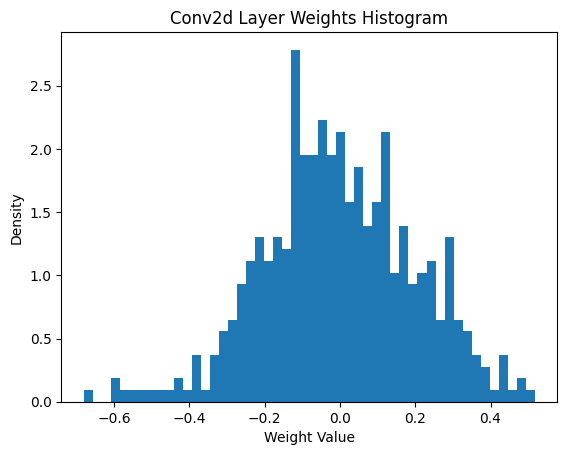

Conv2d Layer Weight Range: 1.197144865989685
Conv2d Layer 3-Sigma Range: 1.2039036750793457


In [25]:
analyze_layer_weights(net.conv1)

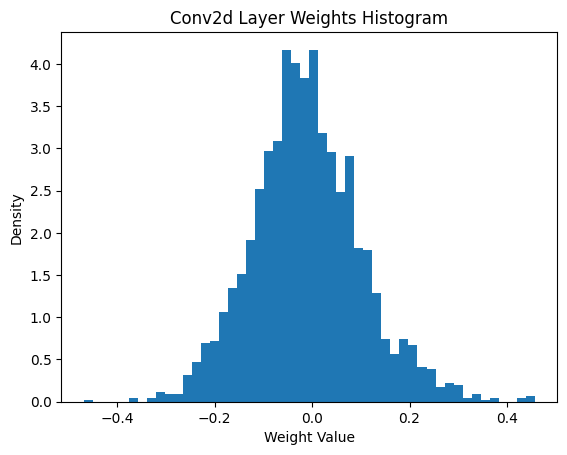

Conv2d Layer Weight Range: 0.924747109413147
Conv2d Layer 3-Sigma Range: 0.6741523742675781


In [26]:
analyze_layer_weights(net.conv2)

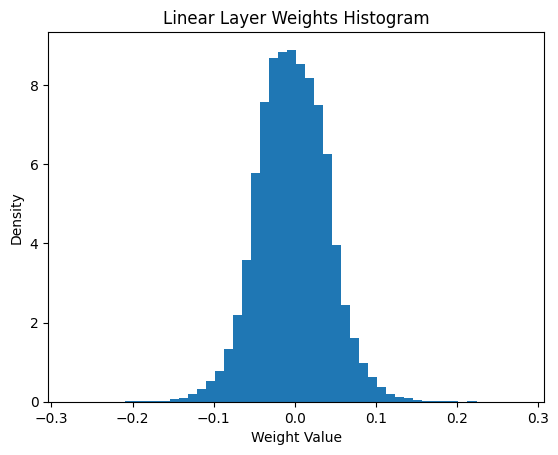

Linear Layer Weight Range: 0.5563050508499146
Linear Layer 3-Sigma Range: 0.25669506192207336


In [27]:
analyze_layer_weights(net.fc1)

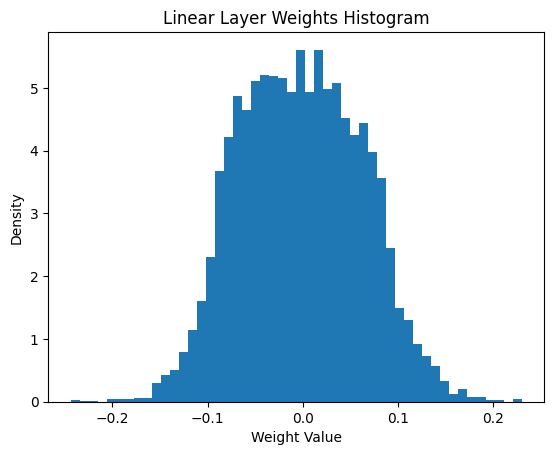

Linear Layer Weight Range: 0.47328659892082214
Linear Layer 3-Sigma Range: 0.3852840065956116


In [28]:
analyze_layer_weights(net.fc2)

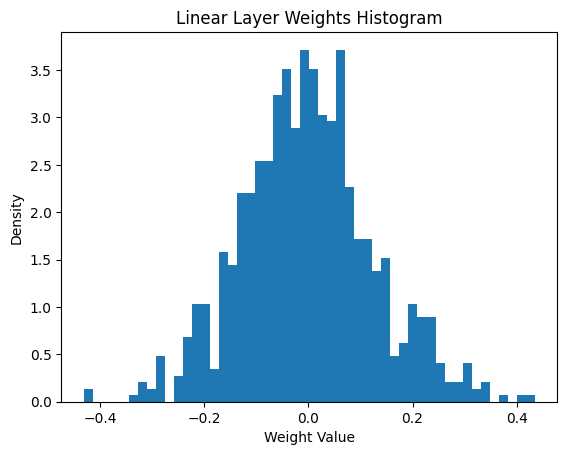

Linear Layer Weight Range: 0.8652147054672241
Linear Layer 3-Sigma Range: 0.7571845650672913


In [29]:
analyze_layer_weights(net.fc3)

# Quantizing Weights

Remember that for matrix multiplication, we had:

$$\mathbf{y} = \mathbf{W}\mathbf{x}$$

If we only quantize weights, we would have the following:

$$\mathbf{y} = \mathbf{W^q}\mathbf{x}$$

In this section, we only quantize the weights and measure the accuracy.

## Copy the model

Take a look at the following function called `copy_model` to deep copy the model. No need to change this.

In [30]:
from copy import deepcopy

def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy over the extra metadata we've collected which copy.deepcopy doesn't capture
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv2d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

In [31]:
net_q2 = copy_model(net)

## Quantize Weights

Complete the following function, `quantized_weights` to quantize the weights.
This function should quantize the weights to 8-bit integers.

In [32]:
import torch
from typing import Tuple

def quantized_weights(weights: torch.Tensor) -> Tuple[torch.Tensor, float]:
    '''
    Quantize the weights so that all values are integers between -128 and 127.
    Use the 3-sigma range for determining the scaling factor.

    Parameters:
    weights (Tensor): The unquantized weights

    Returns:
    (Tensor, float): A tuple with the following elements:
                        * The weights in quantized form, where every value is an integer between -128 and 127.
                          The "dtype" will still be "float", but the values themselves should all be integers.
                        * The scaling factor that your weights were multiplied by.
                          This value does not need to be an 8-bit integer.
    '''

    # TODO: Add your code here.
    # Calculate the 3-sigma range
    weight_3sigma_max = (weights.mean() + 3 * weights.std()).item()
    weight_3sigma_min = (weights.mean() - 3 * weights.std()).item()

    # Calculate the scaling factor
    scale_factor = max(abs(weight_3sigma_max), abs(weight_3sigma_min))

    # Quantize the weights and apply the scaling factor
    quantized_weights = (weights / scale_factor * 127).round().clamp(-128, 127)

    return quantized_weights, scale_factor


In [33]:
# No need to change/modify this.
def quantize_layer_weights(model: nn.Module):
    '''
    Quantizes the weights of Conv2d and Linear layers in a given PyTorch model.

    The function iterates through the child layers of the input model.
    For each Conv2d or Linear layer, it quantizes the weights to ensure
    that every value is an integer between -128 and 127. The scaling factor
    used for quantization is also stored as an attribute of the layer.

    Parameters:
    - model (nn.Module): The input PyTorch model whose weights need to be quantized.

    Raises:
    - Exception: If any quantized weight is out of the range [-128, 127].
    - Exception: If any quantized weight is not an integer.
    '''

    # Iterate through the child layers of the model
    for layer in model.children():

        # Check if the layer is a Conv2d or Linear layer
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):

            # Quantize the weights of the layer using the provided quantized_weights function
            q_layer_data, scale = quantized_weights(layer.weight.data)

            # Move the quantized weights to the same device as the original data
            q_layer_data = q_layer_data.to(device)

            # Replace the original weights with the quantized weights
            layer.weight.data = q_layer_data

            # Store the scaling factor used for quantization as an attribute of the layer
            layer.weight.scale = scale

            # Check if any quantized weight is outside the range [-128, 127]
            if (q_layer_data < -128).any() or (q_layer_data > 127).any():
                raise Exception("Quantized weights of {} layer include values out of bounds for an 8-bit signed integer".format(layer.__class__.__name__))

            # Check if any quantized weight is not an integer
            if (q_layer_data != q_layer_data.round()).any():
                raise Exception("Quantized weights of {} layer include non-integer values".format(layer.__class__.__name__))


quantize_layer_weights(net_q2)

## Measure the accuracy
What is the accuracy of the quantized network?

In [34]:
score = calculate_accuracy(net_q2, testloader)
print('Accuracy of the net_q2 on the test images: {}%'.format(score))

Accuracy of the net_q2 on the test images: 53.1%


## Visualize Activations

In PyTorch, a hook offers a way for users to inspect or adjust the model's internal computations without altering its original structure. The two primary types of hooks are:

1. Forward Hooks:
Used during the forward computational pass to access or adjust layer inputs/outputs.

2. Backward Hooks:
Engaged during the backward pass (during gradient computations) to access or modify gradients.

How to Use Hooks:
Register the hook on a specific module using:
register_forward_hook for forward hooks.
register_backward_hook for backward hooks.
The associated callback function will be triggered when the module processes data.
Hooks serve as a potent tool in PyTorch, invaluable for tasks like debugging, visualization, and tailoring model behavior.

We use these hooks to store the activations in the network.

In [35]:
def append_activations(target_array, x):
    """
    Retrieve the activations from the first sample in the current batch (x[0]),
    transfer them to the CPU, and flatten the multi-dimensional tensor into a 1D array.
    Then, append this flattened array to the given target numpy array, which collects
    the activations for further analysis or storage.

    Parameters:
    - target_array: Existing numpy array where activations will be appended.
    - x: The PyTorch tensor representing the batch of activations.

    Returns:
    - Numpy array with the new activations appended.
    """
    return np.append(target_array, x[0].cpu().view(-1))


def register_activation_profiling_hooks(model: Net):
    """
    Registers hooks on specified layers of a given PyTorch model to profile and
    collect activations during the forward pass. These activations are stored
    directly on the layers as numpy arrays, facilitating tasks like analysis or debugging.

    The function sets an 'activations' attribute on each layer, which gets populated
    with activations as the model processes data.

    Parameters:
    - model (Net): The PyTorch model on which hooks are to be registered.
    """

    # List of layers to register hooks on
    layers = [model.conv1, model.conv2, model.fc1, model.fc2, model.fc3]


    # Register the input_hook to conv1.
    def input_hook(conv1_layer, x):
      """Special hook for input activations, which are captured before conv1"""
      model.input_activations = append_activations(model.input_activations, x)

    model.input_activations = np.empty(0)

    # The hook will be called every time before forward is invoked.
    model.conv1.register_forward_pre_hook(input_hook)

    # Register the hook for the output of each later.
    def generic_hook(layer, x, y):
      """
      A generic hook function designed to be registered with PyTorch layers.
      During the forward pass, it captures the activations from the input tensor,
      flattens them, and appends them to the layer's 'activations' attribute.

      Parameters:
      - layer: The PyTorch layer with which this hook is associated.
      - x: Input tensor to the layer.
      - y: Output tensor from the layer.
      """
      layer.activations = append_activations(layer.activations, x)


    for layer in layers:
        # Initialize an empty numpy array to store activations for each layer
        layer.activations = np.empty(0)

        # Register the generic hook for each layer
        layer.register_forward_hook(generic_hook)

In [36]:
net_q3 = copy_model(net)
register_activation_profiling_hooks(net_q3)

# Run through the training dataset again while profiling the input and output activations this time
calculate_accuracy(net_q3, trainloader, max_samples=400)


55.693069306930695

### Programming Question for Plotting Activations

Write a function to plot the activations of each layer and call it to create all the plots. Record any observations you make about the distribution of the values.

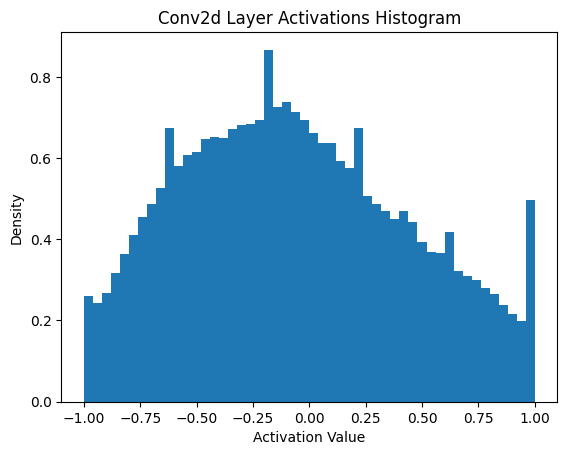

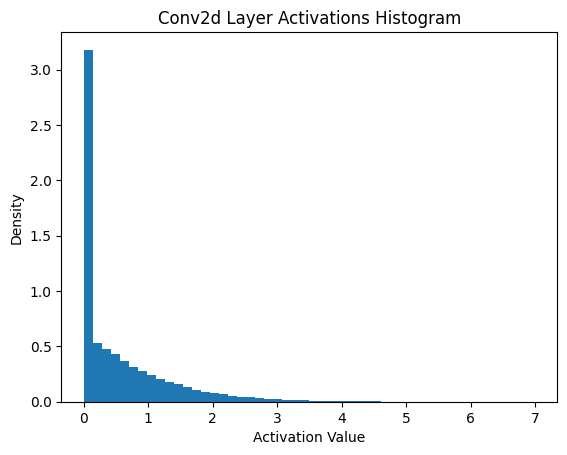

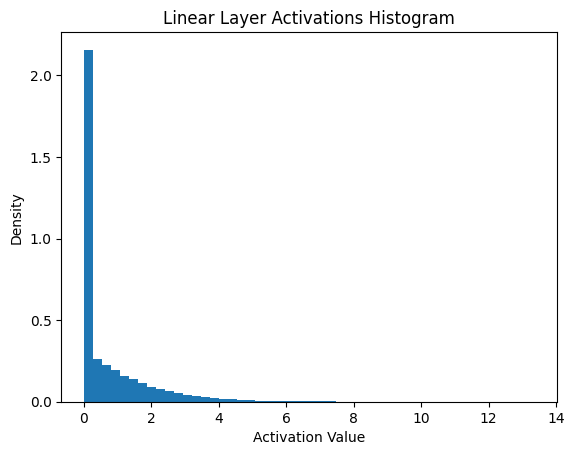

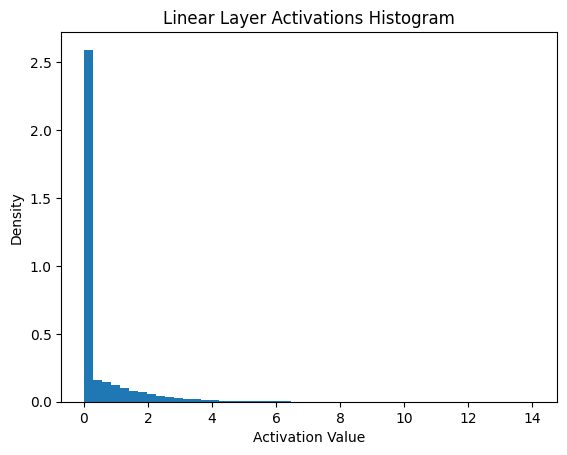

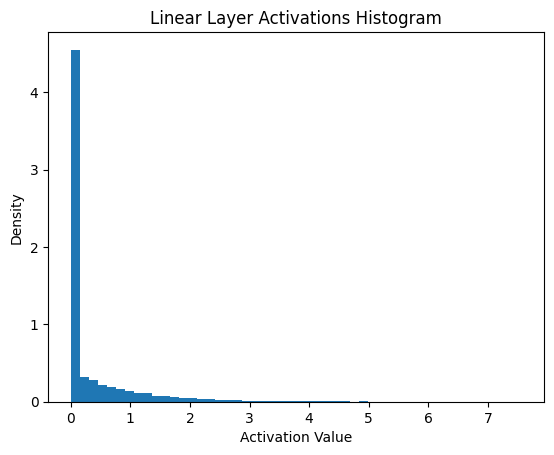

In [37]:
import matplotlib.pyplot as plt

def plot_activations(model: Net):
    """
    Plot histograms of activations for each layer in the given PyTorch model.

    Parameters:
    - model (Net): The PyTorch model whose activations are to be plotted.
    """

    # List of layers to plot activations for
    layers = [model.conv1, model.conv2, model.fc1, model.fc2, model.fc3]

    for layer in layers:
        # Plot histogram of activations
        plt.hist(layer.activations, bins=50, density=True)
        plt.title(f"{type(layer).__name__} Layer Activations Histogram")
        plt.xlabel("Activation Value")
        plt.ylabel("Density")
        plt.show()

# Call the function to plot activations for the quantized model
plot_activations(net_q3)


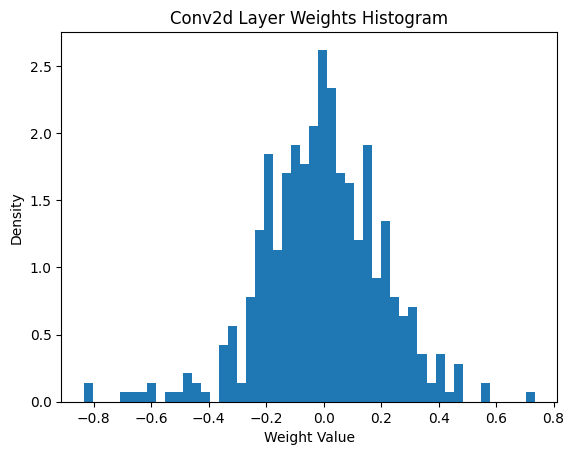

Conv2d Layer Weight Range: 1.568325161933899
Conv2d Layer 3-Sigma Range: 1.2456976175308228


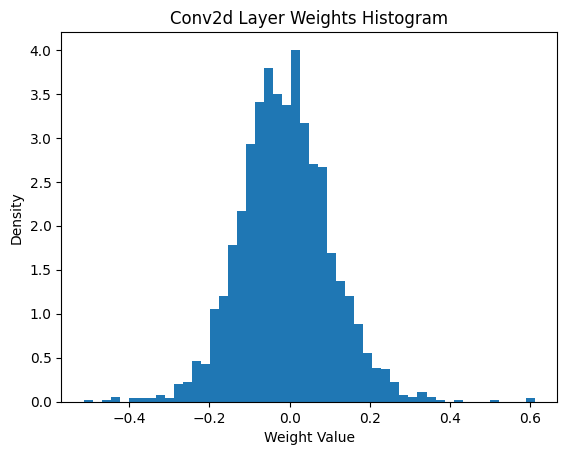

Conv2d Layer Weight Range: 1.1246575117111206
Conv2d Layer 3-Sigma Range: 0.6787152290344238


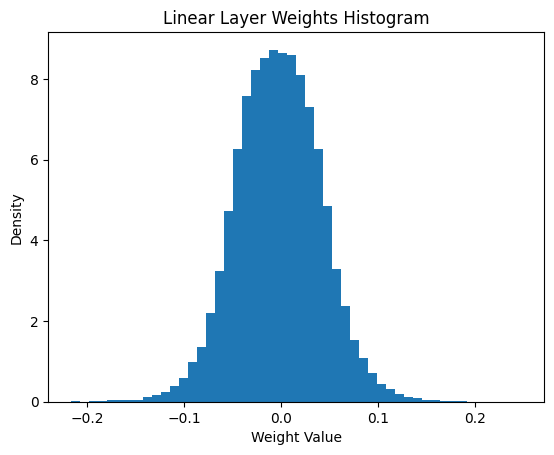

Linear Layer Weight Range: 0.4646121859550476
Linear Layer 3-Sigma Range: 0.2623591423034668


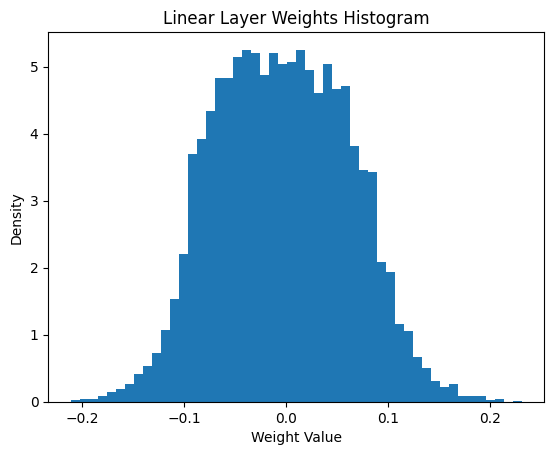

Linear Layer Weight Range: 0.4421491324901581
Linear Layer 3-Sigma Range: 0.3901228904724121


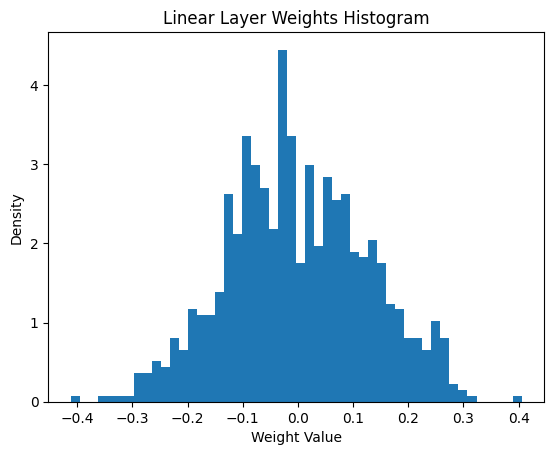

Linear Layer Weight Range: 0.8169668316841125
Linear Layer 3-Sigma Range: 0.7708820700645447


In [26]:
# TODO: Write your code here.


# My code remove this later
def analyze_layer_quantized_weights(layer: nn.Module):
    # Extract and flatten the weights of the given layer
    layer_weights = layer.weight.data.cpu().view(-1)

    # Get layer type (Conv2d or Linear) for better title
    layer_type = type(layer).__name__

    # Plot a histogram of the flattened layer weights
    plt.hist(layer_weights, density=True, bins=50)
    plt.title(f"{layer_type} Layer Weights Histogram")
    plt.xlabel("Weight Value")
    plt.ylabel("Density")
    plt.show()

    # Calculate the upper and lower bounds of the range within 3 standard deviations
    layer_weights_3sigma_max = (layer_weights.mean() + 3 * layer_weights.std()).item()
    layer_weights_3sigma_min = (layer_weights.mean() - 3 * layer_weights.std()).item()

    # Calculate the range of weights and the 3-sigma range for the layer
    weight_range = layer_weights.max() - layer_weights.min()
    sigma_range = layer_weights_3sigma_max - layer_weights_3sigma_min

    print(f"{layer_type} Layer Weight Range: {weight_range.item()}")
    print(f"{layer_type} Layer 3-Sigma Range: {sigma_range}")


analyze_layer_quantized_weights(net_q3.conv1)

analyze_layer_quantized_weights(net_q3.conv2)

analyze_layer_quantized_weights(net_q3.fc1)

analyze_layer_quantized_weights(net_q3.fc2)

analyze_layer_quantized_weights(net_q3.fc3)

## Quantizing Activations

### Formulation Questions

Before performing any quantization let's describe the output of the `conv1` layer as:

$$ W_{conv1} * In = Out_{conv1} $$

Suppose:
- We scale the input, $ In $, scaling it by $ s_{In} $.
- We scale the weight, $ W_{conv1} $, by $ s_{W_{conv1}} $
- We scale output, $ Out_{conv1} $, by $ s_{Out_{conv1}} $.


Now try to answer the following questions:

1. Calculate $ s_{Out_{conv1}}$ and the quantized output of `conv1` layer, $Out_{conv1}^{q}$.

2. Calculate $ s_{Out_{conv2}}$ and the quantized output of `conv2` layer, $Out_{conv2}^{q}$.

3. How would you generalize the output scale calculation to the next layers?


Assume no pooling or relu exists.


$ s_{Out_{conv1}}$ = $ s_{W_{conv1}} $ * $ s_{In_{conv1}} $

$Out_{conv1}^{q}$ =

### Programming Questions

Now we are going to implement a network where both weights and activations are quantized.

To do so, complete these functions in the following code:
1. Understand what the `__init__` function is doing, but it should stay unchanged.
2. Complete `quantize_initial_input`.
3. Complete `quantize_activations`.
4. Write the `forward` function of this quantized network, similar to the original net's `forward` function, but make sure you use `round` and clip the values.


In [45]:
from typing import List, Tuple
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Assume you have the necessary utility functions (e.g., copy_model, calculate_accuracy, etc.) defined elsewhere.

class NetQuantized(nn.Module):
    """
    A PyTorch neural network model with quantized weights and activations.
    """

    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantized, self).__init__()

        net_init = copy_model(net_with_weights_quantized)

        self.conv1 = net_init.conv1
        self.pool = net_init.pool
        self.conv2 = net_init.conv2
        self.fc1 = net_init.fc1
        self.fc2 = net_init.fc2
        self.fc3 = net_init.fc3

        layers = [self.conv1, self.conv2, self.fc1, self.fc2, self.fc3]

        for layer in layers:
            def pre_hook(l, x):
                x = x[0]
                if (x < -128).any() or (x > 127).any():
                    raise Exception("Input to {} layer is out of bounds for an 8-bit signed integer".format(l.__class__.__name__))
                if (x != x.round()).any():
                    raise Exception("Input to {} layer has non-integer values".format(l.__class__.__name__))

            layer.register_forward_pre_hook(pre_hook)

        self.input_activations = net_with_weights_quantized.input_activations
        self.input_scale = NetQuantized.quantize_initial_input(self.input_activations)

        preceding_layer_scales = []
        for layer in layers:
            layer.output_scale = NetQuantized.quantize_activations(layer.activations, layer.weight.scale, self.input_scale, preceding_layer_scales)
            preceding_layer_scales.append((layer.weight.scale, layer.output_scale))

    @staticmethod
    def quantize_initial_input(pixels: np.ndarray) -> float:
        # Calculate the 3-sigma range for the input pixels
        pixel_3sigma_max = (pixels.mean() + 3 * pixels.std()).item()
        pixel_3sigma_min = (pixels.mean() - 3 * pixels.std()).item()

        # Calculate the scaling factor
        input_scale = max(abs(pixel_3sigma_max), abs(pixel_3sigma_min))
        return input_scale

    @staticmethod
    def quantize_activations(activations: np.ndarray, s_w: float, s_initial_input: float, weight_output_scales: List[Tuple[float, float]]) -> float:
        # Calculate the 3-sigma range for the layer activations
        activation_3sigma_max = (activations.mean() + 3 * activations.std()).item()
        activation_3sigma_min = (activations.mean() - 3 * activations.std()).item()

        # Calculate the scaling factor
        activation_scale = max(abs(activation_3sigma_max), abs(activation_3sigma_min))

        # Combine the scales from weights, initial input, and preceding layers
        combined_scale = s_w * s_initial_input
        for weight_scale, output_scale in weight_output_scales:
            combined_scale *= weight_scale * output_scale

        return activation_scale / combined_scale

    def forward(self, x: torch.Tensor) -> torch.Tensor: #Not working
        # Quantize the input
        quantized_input = (x / self.input_scale * 127).round().clamp(-128, 127)

        # Apply the layers with quantized weights and scaled activations
        x = self.pool(F.relu(self.conv1(quantized_input)))
        x = (x / self.conv1.output_scale * 127).round().clamp(-128, 127)

        x = self.pool(F.relu(self.conv2(x)))
        x = (x / self.conv2.output_scale * 127).round().clamp(-128, 127)

        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Quantize the output based on the output scale of the last layer
        quantized_output = (self.fc3(x) / self.fc3.output_scale * 127).round().clamp(-128, 127)

        return quantized_output



In [41]:
from typing import List, Tuple
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Assume you have the necessary utility functions (e.g., copy_model, calculate_accuracy, etc.) defined elsewhere.

class NetQuantized(nn.Module):
    """
    A PyTorch neural network model with quantized weights and activations.
    """

    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantized, self).__init__()

        net_init = copy_model(net_with_weights_quantized)

        self.conv1 = net_init.conv1
        self.pool = net_init.pool
        self.conv2 = net_init.conv2
        self.fc1 = net_init.fc1
        self.fc2 = net_init.fc2
        self.fc3 = net_init.fc3

        layers = [self.conv1, self.conv2, self.fc1, self.fc2, self.fc3]

        for layer in layers:
            def pre_hook(l, x):
                x = x[0]
                if (x < -128).any() or (x > 127).any():
                    raise Exception("Input to {} layer is out of bounds for an 8-bit signed integer".format(l.__class__.__name__))
                if (x != x.round()).any():
                    raise Exception("Input to {} layer has non-integer values".format(l.__class__.__name__))

            layer.register_forward_pre_hook(pre_hook)

        self.input_activations = net_with_weights_quantized.input_activations
        self.input_scale = NetQuantized.quantize_initial_input(self.input_activations)

        preceding_layer_scales = []
        for layer in layers:
            layer.output_scale = NetQuantized.quantize_activations(layer.activations, layer.weight.scale, self.input_scale, preceding_layer_scales)
            preceding_layer_scales.append((layer.weight.scale, layer.output_scale))

    @staticmethod
    def quantize_initial_input(pixels: np.ndarray) -> float:
        # Calculate the 3-sigma range for the input pixels
        pixel_3sigma_max = (pixels.mean() + 3 * pixels.std()).item()
        pixel_3sigma_min = (pixels.mean() - 3 * pixels.std()).item()

        # Calculate the scaling factor
        input_scale = max(abs(pixel_3sigma_max), abs(pixel_3sigma_min))
        return input_scale

    @staticmethod
    def quantize_activations(activations: np.ndarray, s_w: float, s_initial_input: float, weight_output_scales: List[Tuple[float, float]]) -> float:
        # Calculate the 3-sigma range for the layer activations
        activation_3sigma_max = (activations.mean() + 3 * activations.std()).item()
        activation_3sigma_min = (activations.mean() - 3 * activations.std()).item()

        # Calculate the scaling factor
        activation_scale = max(abs(activation_3sigma_max), abs(activation_3sigma_min))

        # Combine the scales from weights, initial input, and preceding layers
        combined_scale = s_w * s_initial_input
        for weight_scale, output_scale in weight_output_scales:
            combined_scale *= weight_scale * output_scale

        return activation_scale / combined_scale

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Quantize the input
        quantized_input = (x / self.input_scale * 127).round().clamp(-128, 127)

        # Apply the layers with quantized weights and scaled activations
        x = self.pool(F.relu(self.conv1(quantized_input)))
        x = (x / self.conv1.output_scale * 127).round().clamp(-128, 127)

        x = self.pool(F.relu(self.conv2(x)))
        x = (x / self.conv2.output_scale * 127).round().clamp(-128, 127)

        x = x.view(-1, 16 * 5 * 5)
        x = (F.relu(self.fc1(x)) / self.fc1.output_scale * 127).round().clamp(-128, 127)
        x = (F.relu(self.fc2(x)) / self.fc2.output_scale * 127).round().clamp(-128, 127)

        # Quantize the output based on the output scale of the last layer
        quantized_output = (self.fc3(x) / self.fc3.output_scale * 127).round().clamp(-128, 127)

        return quantized_output


In [46]:
# No need to change this code
# Merge the information from net_q2 and net_q3 together
net_init = copy_model(net_q2)
net_init.input_activations = deepcopy(net_q3.input_activations)
for layer_init, layer_q3 in zip(net_init.children(), net_q3.children()):
    if isinstance(layer_init, nn.Conv2d) or isinstance(layer_init, nn.Linear):
        layer_init.activations = deepcopy(layer_q3.activations)

net_quantized = NetQuantized(net_init)

## Calculate the accuracy

1. What is the accuracy of `net_quantized`?
2. What can you say about quantization and the accuracy of the network?

In [47]:
score = calculate_accuracy(net_quantized, testloader)
print('Accuracy of the net_quantized on the test images: {}%'.format(score))

Accuracy of the net_quantized on the test images: 17.93%


## Enhancement and Optimization Questions
1. Write down the scaling factors you calculated in the previous section for each layer. Instead of reporting the scale factor itself, $s$, report $\frac{1}{s}$ for each layer.

2. Modify the network so that you round each $\frac{1}{s}$ for activations to the nearest power of 2 and use that instead. For example, if $\frac{1}{s} = 230.46005$, round it to $256$.
 - What is the benefit of this approximation?
 - Recalculate the accuracy.

3. Instead of 8-bit integers, modify your code to use 4-bit integers. Recalculate the accuracy.